### 1.Load and normalizing the CIFAR10 datasets

In [286]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 125
epochs = 10
learning_rate = 0.001
momentum = None

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### showing some of the training images

truck  ship  ship plane
torch.Size([125, 3, 32, 32])


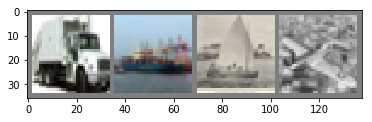

In [287]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print(images.size())

#### Define tensorboard writer

In [288]:
from tensorboardX import SummaryWriter

writer = SummaryWriter(
    comment='[ADAM+net_edit] batch_size={}, epochs={}, lr={}, momentum={}'.format(batch_size, epochs, learning_rate, momentum)
)

### 2. Define a Convolution Neural Network

In [289]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        #self.drop = nn.Dropout(p=0.3)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3. Define a Loss function and optimizer

In [290]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

### 4. Train the network

In [291]:
for epoch in range(epochs):

    running_loss = 0.0
    total_batch = len(trainset)//batch_size
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total = labels.size(0)
        
        
        #Recoding on tensorboard
        writer.add_scalar('Train/Loss', loss, epoch*total_batch+i)
        writer.add_scalar('Train/Accuracy', correct/total, epoch*total_batch+i)


        running_loss += loss.item()
        printing_unit = total_batch // 5
        if i % printing_unit == printing_unit-1 :    # print every 100 mini-batches
            print('[{}, {}] loss: {:f}'.format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1, 80] loss: 0.076899
[1, 160] loss: 0.063842
[1, 240] loss: 0.058832
[1, 320] loss: 0.055267
[1, 400] loss: 0.051627
[2, 80] loss: 0.048865
[2, 160] loss: 0.047720
[2, 240] loss: 0.045848
[2, 320] loss: 0.044004
[2, 400] loss: 0.042501
[3, 80] loss: 0.039739
[3, 160] loss: 0.039621
[3, 240] loss: 0.037942
[3, 320] loss: 0.038190
[3, 400] loss: 0.036834
[4, 80] loss: 0.034492
[4, 160] loss: 0.033343
[4, 240] loss: 0.033762
[4, 320] loss: 0.034036
[4, 400] loss: 0.032963
[5, 80] loss: 0.029807
[5, 160] loss: 0.029919
[5, 240] loss: 0.030746
[5, 320] loss: 0.029814
[5, 400] loss: 0.029970
[6, 80] loss: 0.026456
[6, 160] loss: 0.026561
[6, 240] loss: 0.026477
[6, 320] loss: 0.026128
[6, 400] loss: 0.027065
[7, 80] loss: 0.022805
[7, 160] loss: 0.022627
[7, 240] loss: 0.023868
[7, 320] loss: 0.023574
[7, 400] loss: 0.024130
[8, 80] loss: 0.019342
[8, 160] loss: 0.019956
[8, 240] loss: 0.021037
[8, 320] loss: 0.020658
[8, 400] loss: 0.020697
[9, 80] loss: 0.017200
[9, 160] loss: 0.017033
[

### 5. Test the network

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship plane


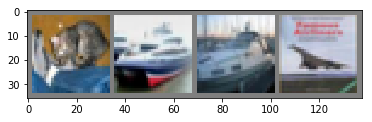

In [292]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [293]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

writer.add_scalar('Test/Accuracy', correct/total, 1)

Accuracy of the network on the 10000 test images: 71 %


#### Close the tensorboard writer

In [294]:
writer.close()